# Siamese Neural Network

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 00:57:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from scipy.fft import fftshift
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
os.chdir("drive/My Drive/ML final project/openmic-2018")
!ls "/content/drive/My Drive/ML final project/openmic-2018"

acknowledgement.md  license-cc-by.txt			   openmic-2018.npz
audio		    openmic-2018-aggregated-labels.csv	   partitions
checksums	    openmic-2018-individual-responses.csv  vggish
class-map.json	    openmic-2018-metadata.csv


In [ ]:
# Quick note on the terms:
# .json: VGGish features as JSON objects, in a directory format like 'vggish/{0:3}/{0}.json'.format(sample_key)
# .ogg: 10 second snippets of audio, in a directory format like 'audio/{0:3}/{0}.ogg'.format(sample_key)
# .npz: A Python-friendly NPZ file of features and labels, 'openmic-2018.npz'
# VGGish: 

# Now we need to read in .json file for each track and transform them into
# spectrograms for latter input into the neural network
openmic = np.load('openmic-2018.npz', allow_pickle=True)
# Use allow_pickle = True so later the sample_key could be properly loaded

In [ ]:
meta_data = pd.read_csv('openmic-2018-metadata.csv')

In [ ]:
print(type(meta_data))
print(meta_data.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['track_id', 'album_id', 'album_title', 'album_url', 'artist_id',
       'artist_name', 'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favorites', 'track_file', 'track_genres', 'track_image_file',
       'track_information', 'track_instrumental', 'track_interest',
       'track_language_code', 'track_listens', 'track_lyricist',
       'track_number', 'track_publisher', 'track_title', 'track_url',
       'sample_key', 'start_time'],
      dtype='object')


In [ ]:
print(meta_data['track_genres'])
print(type(meta_data['track_genres']))
# See one example
print(meta_data['track_genres'][22])
# We will only select the first genre (genre_id) as the label for the song
#print(meta_data['track_instrumental'])

0        [{'genre_id': '76', 'genre_title': 'Experiment...
1        [{'genre_id': '45', 'genre_title': 'Loud-Rock'...
2        [{'genre_id': '17', 'genre_title': 'Folk', 'ge...
3        [{'genre_id': '17', 'genre_title': 'Folk', 'ge...
4        [{'genre_id': '4', 'genre_title': 'Jazz', 'gen...
                               ...                        
19995    [{'genre_id': '18', 'genre_title': 'Soundtrack...
19996    [{'genre_id': '18', 'genre_title': 'Soundtrack...
19997    [{'genre_id': '1', 'genre_title': 'Avant-Garde...
19998    [{'genre_id': '1', 'genre_title': 'Avant-Garde...
19999    [{'genre_id': '1', 'genre_title': 'Avant-Garde...
Name: track_genres, Length: 20000, dtype: object
<class 'pandas.core.series.Series'>
[{'genre_id': '12', 'genre_title': 'Rock', 'genre_url': 'http://freemusicarchive.org/genre/Rock/'}, {'genre_id': '76', 'genre_title': 'Experimental Pop', 'genre_url': 'http://freemusicarchive.org/genre/Experimental_Pop/'}]


In [ ]:
print(type(meta_data['track_genres'].loc[0]))
print(type(meta_data['track_genres'].loc[167]))

<class 'str'>
<class 'float'>


In [ ]:
print(type(meta_data['sample_key']))
print(np.shape(meta_data['sample_key']))
# See on example
print(meta_data['sample_key'][22])
print(type(meta_data['sample_key'][22]))

<class 'pandas.core.series.Series'>
(20000,)
000248_157440
<class 'str'>


In [ ]:
# We now extract the first index (genre_id) and store them into
# a dictironary as the label set connecting to the sample key

import math

genre_label = {}

for i in range(20000):
  # in case some track has no corresponding information
  if type(meta_data['track_genres'].loc[i]) == type(3.4): # If they are float, suggesting it's nan
    genre_label[meta_data['sample_key'][i]] = -1
  else:
    genres_ser_i = meta_data['track_genres'].loc[i] # Strangely, this is a string
    #print(type(genres_ser_i), i)
    genres_list_i = genres_ser_i.split() # Convert it into a list
    index_i = genres_list_i[1][1:-2] # Cut the index out
    genre_label[meta_data['sample_key'][i]] = np.float(index_i)

print(len(genre_label))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


20000


In [ ]:
#print(genre_label)

### Step 0. Conversion from ogg to spectrogram

In [ ]:
examples = dict()
count = 0
done = False
MAX_COUNT = 500 # Number of data imported/converted


for subdir, dirs, files in os.walk("audio"):
  if done == True:
    break
  for file in files:
      filepath = subdir + os.sep + file
    
      if filepath.endswith(".ogg"):
        outerNum = subdir.split("/")[1]
        fileNoExtension = file.split(".")[0]
        newFolderPath = "/content/drive/My Drive/ML final project/spectrograms" + os.sep + outerNum
        data, sampleRate = librosa.load(filepath)
        f, t, Sxx = signal.spectrogram(data, fs=sampleRate)

        # Convert Sxx unit from dB to Hz
        Sxx = 10*np.log10(Sxx)

        name = outerNum + "_" + fileNoExtension

        examples[name] = Sxx
        count += 1
        if count >= MAX_COUNT:
          done = True
          break
        if count % 40 == 1:
          print(count)

        ### to generate and save spectrogram images

        # # Colormesh Plot
        # plt.pcolormesh(t, f, Sxx, shading='gouraud')
        # plt.ylabel('Frequency [Hz]')
        # plt.xlabel('Time [sec]')

        # if not os.path.isdir(newFolderPath):
        #   os.makedirs(newFolderPath)
        
        # newFilePath = newFolderPath + os.sep + fileNoExtension + ".jpeg"
        # plt.savefig(newFilePath)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


41
81
121
161
201
241
281
321
361
401
441
481


In [ ]:
#print(examples.keys())
examples_copy = examples.copy()

In [ ]:
# Get rid of the "XXX" indices at the front 
for key in examples_copy.keys():
  new_key = key.split("_")
  #print(new_key)
  if len(new_key) < 3:
    new_key.append(new_key[-1])
    new_key[-1] = "_"
    new_key = ''.join(new_key)
  else:
    new_key = new_key[1] + "_" + new_key[2]
  examples[new_key] = examples[key] # Change the keys for the original variable
  del examples[key]

In [ ]:
print(examples.keys())

dict_keys(['122205_130560', '122003_119040', '122026_69120', '122195_7680', '122027_30720', '122202_7680', '122120_30720', '122242_84480', '122151_19200', '122155_99840', '122131_57600', '122065_145920', '122012_168960', '122043_126720', '122040_126720', '122153_138240', '122004_96000', '122118_30720', '122204_222720', '122216_7680', '122504_57600', '122697_226560', '122796_307200', '122658_61440', '122683_46080', '122810_76800', '122657_245760', '122560_15360', '122567_10187520', '122672_549120', '122329_42240', '122684_111360', '122371_414720', '122201_165120', '122661_122880', '122829_887040', '122533_53760', '122610_195840', '122257_42240', '122389_19200', '122465_7680', '122561_19200', '122785_115200', '122584_99840', '122370_257280', '122664_307200', '122423_126720', '122589_218880', '122615_307200', '122625_184320', '122667_99840', '122363_46080', '122665_172800', '122602_414720', '122656_0', '122680_122880', '122518_215040', '122369_180480', '122588_11520', '122621_280320', '12

In [ ]:
# Construct the 3D data list
data = []

for key in examples.keys():
  data.append(examples[key])

print(np.shape(data))

(500, 129, 984)


In [ ]:
# Construct the corresponding labels
label = []

for key in examples.keys():
  label.append(genre_label[key])

In [ ]:
print(label)
print(len(label))
print(type(label))

[1.0, 38.0, 27.0, 14.0, 27.0, 1.0, 12.0, 21.0, 1.0, 1.0, 12.0, 3.0, 19.0, 15.0, 27.0, 1.0, 38.0, 12.0, 1.0, 21.0, 10.0, 15.0, 1.0, 18.0, 12.0, 76.0, 18.0, 15.0, 267.0, 267.0, 5.0, 12.0, 74.0, 1.0, 18.0, 88.0, 10.0, 12.0, 38.0, 32.0, 66.0, 15.0, 1.0, 15.0, -1, 18.0, 15.0, 250.0, 12.0, 18.0, 18.0, 103.0, 18.0, 15.0, 18.0, 12.0, 103.0, -1, 15.0, 1235.0, 15.0, 32.0, 12.0, 15.0, 1235.0, 1.0, 10.0, 18.0, 43.0, 32.0, 18.0, 15.0, 38.0, 18.0, 12.0, 15.0, 12.0, 12.0, 250.0, 32.0, 12.0, 18.0, 17.0, 15.0, 10.0, 18.0, 4.0, 103.0, 15.0, 15.0, 10.0, 18.0, 15.0, 5.0, 88.0, 12.0, 8.0, 18.0, 74.0, 15.0, 18.0, 4.0, 12.0, 66.0, 15.0, 17.0, 250.0, 36.0, 103.0, 10.0, 103.0, 12.0, 10.0, 18.0, 10.0, 1.0, 41.0, 1.0, 5.0, 1.0, 1.0, 18.0, 1.0, 1.0, 36.0, 33.0, 1.0, 17.0, 1.0, 15.0, 17.0, 1.0, 18.0, 1235.0, 15.0, 1.0, 18.0, 18.0, 1.0, 33.0, 25.0, 33.0, 33.0, 15.0, 3.0, 47.0, 3.0, 4.0, 107.0, 15.0, 4.0, 4.0, 15.0, 25.0, 15.0, 25.0, 66.0, 3.0, 66.0, 10.0, 33.0, 4.0, 15.0, 33.0, 33.0, 33.0, 25.0, 25.0, 33.0, 15.0, 1

In [ ]:
print(np.shape(data))
print(np.shape(label))
print(np.shape(np.unique(label)))

(500, 129, 984)
(500,)
(53,)


In [ ]:
print(np.max(label))
print(np.min(label))
print(np.unique(label))
print(np.max(data))
print(np.min(data)) # So we need to fix this issue!
print(np.median(data))

1235.0
-1.0
[-1.000e+00  1.000e+00  2.000e+00  3.000e+00  4.000e+00  5.000e+00
  6.000e+00  7.000e+00  8.000e+00  1.000e+01  1.200e+01  1.400e+01
  1.500e+01  1.700e+01  1.800e+01  1.900e+01  2.100e+01  2.200e+01
  2.500e+01  2.600e+01  2.700e+01  3.000e+01  3.100e+01  3.200e+01
  3.300e+01  3.600e+01  3.800e+01  4.100e+01  4.200e+01  4.300e+01
  4.700e+01  5.800e+01  6.600e+01  7.400e+01  7.600e+01  8.800e+01
  1.030e+02  1.070e+02  1.810e+02  1.820e+02  2.400e+02  2.500e+02
  2.670e+02  2.860e+02  2.960e+02  3.220e+02  3.620e+02  4.000e+02
  4.560e+02  4.680e+02  5.390e+02  8.110e+02  1.235e+03]
-21.383917
-inf
-87.40617


In [ ]:
print(np.min(data))
print(np.min(data) == -np.float('inf'))

-inf
True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
data_med = np.median(data)
data = np.where(data != np.min(data), data, data_med)

In [ ]:
print(np.min(data))
print(np.shape(data))

-448.5347
(500, 129, 984)


## Classification based on Siamese Neural Network

For Siamese neural network, we need the actual audio signals and transform them into spectorgrams as the input for SNN. 

The following codes for siamese neural network setup are adapted from pyimagesearch.com by Adrian Rosebrock.
https://pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/;
https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/;
https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/;




### Step 1. Image Pairs

In [ ]:
# 1]. Build Image Pairs

def make_pairs(image, labels):
  # Initialize with two empty lists
  # Notice each data from image appears at least once in the pairs. 
  imagePair = []
  labelPair = []

  # Now we find the total number of unique classes
  label_unique = np.unique(labels)

  # Also need to store the indices for each class at each input
  index = {}
  for i in label_unique:
    index[i] = list(np.where(np.array(labels) == i)[0])
  # np.where only works for np.array type data. 


  # Generate positive and negative pairs
  for i in range(len(image)):
    image_current = image[i]
    label_current = labels[i]
    
    # Then randomly choose an index from the same class
    random_index_pos = np.random.choice(index[int(label_current)])

    image_positive = image[random_index_pos]
    
    # Append image pairs. If positive, assign 1; -1 otherwise.
    imagePair.append([image_current, image_positive]) # Positive pair (same class)
    labelPair.append(1)

    # Also assign negative image pairs
    random_index_neg_array = np.where(np.array(labels) != label_current)[0] 
    # This is an array
    random_index_neg = np.random.choice(random_index_neg_array)
    image_negative = image[random_index_neg]
    
    # Append image paris. Now negative.
    imagePair.append([image_current, image_negative]) # Negative pair (different class)
    labelPair.append(0)

  return (np.array(imagePair), np.array(labelPair)) # Returned as np.array for later analysis


### Step 2. Build the Siamese Neural Network

In [ ]:
# Based on the previous pair-generation process, now we could build the 
# Siamese neural network (the network would learn both the similarities between
# images of the same class and the distinctions among different classes, and updates
# the weights accordingly and concurrently for both branches)
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K


2.8.0


In [ ]:
# Write function to define the Siamese neural network and the related objectives


def construct_snn(inputSize, embeddingDim=48):
  # This is construction for one branch
  # inputSize: Spatial dimensions
  # embeddingDim: Output dimensionality of the fc layer

  input = Input(inputSize)

  # Define the CNN layers
  # Conv --> ReLu --> Pool --> Dropout --> Conv --> ReLu --> Pool --> Dropout

  # Parameters need changing
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(input)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.3)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  output = Dense(embeddingDim)(pooledOutput)
  model = Model(input, output)

  return model


In [ ]:
def distance(vectors):
  # Calculte the distance between output vectors of
  # the fully connected layer of the sister neural networks. 
  
  # The reason we use this complicated form is that we want to 
  # calculate the distance inside the Siamese neural network structure.
  # Use a custom Lambda layer to embed Keras/TensorFlow functions inside of a model
  (vector1, vector2) = vectors
  sumSquared = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
  
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H):
	# H: the training history
	plt.style.use("ggplot")
	plt.figure()
 
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

### Step 3. Training the neural network

In [ ]:
# Now we train our Siamese neural network with the spectrogram data:

# These are the actual 2D arrays for the spectrograms
from sklearn.model_selection import train_test_split

# Convert list into np.array
data = np.array(data)
label = np.array(label)


# Train-test-split
image_train, image_test, lab_train, lab_test = train_test_split(data, label, test_size=0.3, random_state=42)



# Add a dimension
image_train = np.expand_dims(image_train, axis=-1)
image_test = np.expand_dims(image_test, axis=-1)


# Import the actual shape of the spectrogram
# How many input spectrograms we have
input_size = MAX_COUNT   #  Defined above when we do conversion from ogg to spectrogram
# The shape of each input spectrogram, e.g., (28, 28, 1)
image_shape = (129, 984, 1) 
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
# Firstly, use make_pairs() on input spectrograms 
# (already divided into train and test sets)
(pair_train, label_train)   = make_pairs(image_train, lab_train) 
(pair_test, label_test) = make_pairs(image_test, lab_test) 


# Construct the cnn layers
print("[INFO] building siamese network...")
spectrogram1 = Input(shape = image_shape)
spectrogram2 = Input(shape = image_shape)
featureExtractor = construct_snn(image_shape)
feat_spec1 = featureExtractor(spectrogram1)
feat_spec2 = featureExtractor(spectrogram2)
# Note we only implement construct_snn once since the siamese neural network
# has two mirror branches with the exact same weights/parameters that are updated 
# at the same time. 

# Construct the end layers and calculate for the sigmoid function
# Employ the Lambda layer to compute distance between two output vectors
distance_spec = Lambda(distance)([feat_spec1, feat_spec2])

# Sigmoid activation layer
# The sigmoid activation function is used here. 
# If the output is closer to 0, then it indicates that the two images are very 
# unlikely to be from the same class. On the other hand, if the output is closer to
# 1, then the images likely come from the same class.
output = Dense(1, activation="sigmoid")(distance_spec)

# Construct the model
model = Model(inputs=[spectrogram1, spectrogram2], outputs=output)


[INFO] building siamese network...


In [ ]:
# Actual training
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# Binary cross-entropy is used here because this is two-class 
# classification. Our goal is to determine whether the images aare from 
# the same class or not. 

# More advanced loss functions can be used here as well, including triplet loss and contrastive loss
# (if we implement the network as three branches instead of two).

# Training the model
history = model.fit(
	[pair_train[:, 0], pair_train[:, 1]], label_train[:],
	validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

Epoch 1/20
22/22 [==============================] - 32s 250ms/step - loss: 0.9375 - accuracy: 0.5000 - val_loss: 0.6836 - val_accuracy: 0.5967
Epoch 2/20
22/22 [==============================] - 5s 213ms/step - loss: 0.7005 - accuracy: 0.5000 - val_loss: 0.6877 - val_accuracy: 0.6033
Epoch 3/20
22/22 [==============================] - 5s 213ms/step - loss: 0.6952 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5733
Epoch 4/20
22/22 [==============================] - 5s 213ms/step - loss: 0.6922 - accuracy: 0.5014 - val_loss: 0.6900 - val_accuracy: 0.5667
Epoch 5/20
22/22 [==============================] - 5s 213ms/step - loss: 0.6918 - accuracy: 0.5057 - val_loss: 0.6903 - val_accuracy: 0.5767
Epoch 6/20
22/22 [==============================] - 5s 212ms/step - loss: 0.6911 - accuracy: 0.5386 - val_loss: 0.6891 - val_accuracy: 0.5733
Epoch 7/20
22/22 [==============================] - 5s 213ms/step - loss: 0.6903 - accuracy: 0.5514 - val_loss: 0.6883 - val_accuracy: 0.5767
Epoch

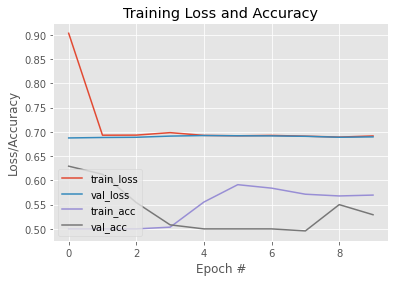

In [ ]:
# Plot the training results
plot_training(history)

### Step 4. Prediction

##### We can then use the trained Siamese neural network, specifically the last layer for making predictions on data outside our train/dev sets.

If the sigmoid output is larger than 0.5, then we classify the two input images as coming from the same class.

In [ ]:
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import random

In [ ]:
# Firstly, construct image pairs

# User input of the already existed playlist

# This is again actual 2D arrays for spectrograms of the testing images/user input
# Suppose user has a playlist including 5 songs which 
# we generate here with some randomness

# test is a list of spectrograms for the songs in the playlist
dataset_size = len(data)
test = []

user_list_index = random.sample(range(0, dataset_size), 5)
for i in user_list_index:
  test.append(data[i])

num_test = len(test)

#ratio = 0.8 # Randomly select a portion of the image set for making pairs
#image_compare = random.sample(data, np.int(ratio*dataset_size))
image_compare = data

pairs = []
# Store image pairs of each of the testing image with the image data we already have
for i in range(len(test)):
  l = []
  for j in range(len(image_compare)):
    l.append([test[i], image_compare[j]])
  pairs.append(l)
  # pairs would be a 4D structure


# Variable for storing similarity scores between all image pairs
simi_score = []

# Implement the snn over all image pairs
for i in range(len(pairs)):
  # Refresh each time we do the loop for a different testing song/spectrogram/image
  score_i = []

  for (j, (spec1, spec2)) in enumerate(pairs[i][:]):
    # create a copy of both the images for visualization purpose
    orig_spec1 = spec1.copy()
    orig_spec2 = spec2.copy()

    spec1 = np.expand_dims(spec1, axis=-1)
    spec2 = np.expand_dims(spec2, axis=-1)

    spec1 = np.expand_dims(spec1, axis=0)
    spec2 = np.expand_dims(spec2, axis=0)

    #print(np.shape(spec1))
    #print(np.shape(spec2))
    
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    predict = model.predict([spec1, spec2])
    similarity = predict[0][0]
    # Update to the score list
    score_i.append(similarity)
    
    # Display spectrogram pairs and show predicted similarity scores
    #fig = plt.figure("Pair #{}".format(j + 1), figsize=(4, 2))
    #plt.suptitle("Similarity: {:.2f}".format(similarity))
    
    #ax = fig.add_subplot(1, 2, 1)
    #plt.imshow(orig_spec1, cmap=plt.cm.gray)
    #plt.axis("off")
    
    #ax = fig.add_subplot(1, 2, 2)
    #plt.imshow(orig_spec2, cmap=plt.cm.gray)
    #plt.axis("off")
    
    #plt.show()
  
  simi_score.append(score_i)


In [ ]:
print(np.shape(simi_score))

In [ ]:
from math import inf
# Eventually, now we output the recommended indices of the songs in our dataset!

# User input of how many songs he/she wants from the system
num_rec = input("How many songs you would like me to recommend:\n")
simi_score_orig = simi_score # Make a copy in case we need it

# The list for final recommendation
rec_list = []

i = 0
while i < int(num_rec):
  # The reason we don't use a for loop is because there might be 
  # cases where the same song/track in the dataset has been selected 
  # for recommendation, in which case we have to recommend another song/track

  max_simi = np.max(simi_score)
  max_index = np.argmax(simi_score) # in the unlikely event that simi_score has
  # two exact scores, np.argmax is only going to return the first index
  # Also notice that this index is for the flattened out version of simi_score
  
  q = (max_index + 1) // dataset_size 
  r = (max_index + 1) % dataset_size
  
  if r != 0:
    dataset_index_row = q
    dataset_index_col = r - 1
  else:
    dataset_index_row = q - 1
    dataset_index_col = dataset_size - 1

  #print(dataset_index_row)
  #print(dataset_index_col)
  
  simi_score[dataset_index_row][dataset_index_col] = -np.inf
  
  # In case the same song is selected again, we need to continue the looping/searching
  rec_list.append(dataset_index_col)
  if len(rec_list) > 1 and (rec_list[-1] == rec_list[-2]) :
    del rec_list[-1]
  else:
    i = i + 1

print("The recommended songlist is (song indices): ", rec_list)

NameError: ignored

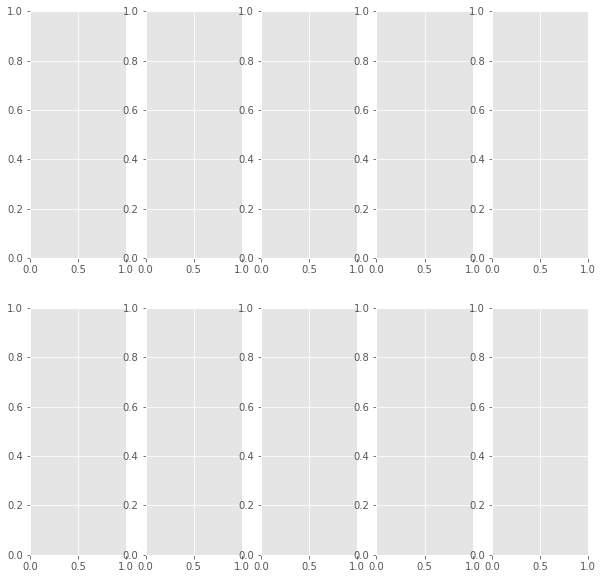

In [ ]:
# Now following on that, we could have a check of 
# our final recommendation in spectrogram:

# The user playlist index list is user_list_index
# The recommended song index list is rec_list
from scipy import signal


fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (10,10))
for c in range(10):

  if c < 5:
    image = data[user_list_index[c]]

    f, t, Sxx = signal.spectrogram(image)
    # Convert Sxx unit from dB to Hz
    Sxx = 10*np.log10(Sxx)
    
    pcolormesh(t, f, Sxx, shading='gouraud')
    np.ravel(ax)[c].set_title('User list Song ' + str(c+1))
    np.ravel(ax)[c].set_xlabel('frequency')
    np.ravel(ax)[c].set_ylabel('Amplitude')
    #plt.colorbar(im, ax=np.ravel(ax)[c], shrink = 0.8)

  else:
    image = data[rec_list[c-5]]
    
    im = np.ravel(ax)[c].imshow(image, clim=[0, 255], cmap='jet')
    np.ravel(ax)[c].set_title('User list Song ' + str(c-5+1))
    np.ravel(ax)[c].set_xlabel('frequency')
    np.ravel(ax)[c].set_ylabel('Amplitude')
    #plt.colorbar(im, ax=np.ravel(ax)[c], shrink = 0.8)    



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


(129,)
(566,)
(129, 566)


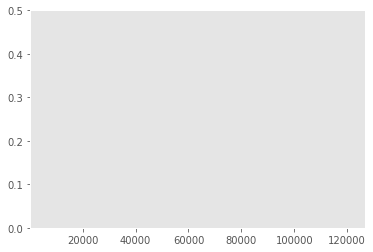

In [ ]:
c = 1
image = data[user_list_index[c]]

def flatten(t):
    return [i for sublist in t for item in sublist]

f, t, Sxx = signal.spectrogram(np.array(flatten(image)))
# Convert Sxx unit from dB to Hz
Sxx = 10*np.log10(Sxx)
print(np.shape(f))
print(np.shape(t))
print(np.shape(Sxx))

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.show()

